<a href="https://colab.research.google.com/github/ioanabuze/DE_Group_Project_2020/blob/master/Amazon_Review_Weak_Labelling_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Code here to push the Notebook to Git
# HEllo! :)
# have been changed again

In [5]:
# Import Libraries, OS and Setup 
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from pyspark.sql import SQLContext

In [6]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [7]:
import pyspark

number_cores = 8
memory_gb = 24
conf = (
    pyspark.SparkConf()
        .setMaster('local[{}]'.format(number_cores))
        .set('spark.driver.memory', '{}g'.format(memory_gb))
)
sc = pyspark.SparkContext(conf=conf)

In [8]:
rdd = sc.parallelize([1, 4, 9])
sum_squares = rdd.map(lambda elem: float(elem)**2).sum()
sum_squares

98.0

In [9]:
number_cores = int(os.environ['NUM_CPUS'])
memory_gb = int(os.environ['AVAILABLE_MEMORY_MB']) // 1024

In [10]:
#Import the Data
sqlContext = SQLContext(sc)

amazon_reviews_dataset_sql_context = sqlContext.read.csv("Ioana_Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv",header=True)
amazon_reviews_dataset_rdd = amazon_reviews_dataset_sql_context.rdd
amazon_reviews_dataset_pd_df = pd.read_csv("Ioana_Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv", engine='python')

In [11]:
#amazon_reviews_dataset_pd_df.isna().sum()

In [12]:
amazon_reviews_dataset_sql_context=amazon_reviews_dataset_sql_context.withColumnRenamed("reviews.title","reviews_title")
amazon_reviews_dataset_sql_context=amazon_reviews_dataset_sql_context.withColumnRenamed("reviews.text","reviews_text")
amazon_reviews_dataset_sql_context=amazon_reviews_dataset_sql_context.withColumnRenamed("reviews.rating","reviews_rating")
amazon_reviews_dataset_sql_context=amazon_reviews_dataset_sql_context.withColumnRenamed("reviews.date","reviews_date")

In [13]:
#amazon_reviews_dataset_sql_context.printSchema()

In [14]:
simplified_amazon_reviews_dataset_sql_contex = amazon_reviews_dataset_sql_context.select("reviews_rating",  "reviews_text", "reviews_title")
simplified_amazon_reviews_dataset_sql_contex.show()

+--------------+--------------------+--------------------+
|reviews_rating|        reviews_text|       reviews_title|
+--------------+--------------------+--------------------+
|             3|I thought it woul...|           Too small|
|             5|This kindle is li...|Great light reade...|
|             4|Didnt know how mu...| Great for the price|
|             5|I am 100 happy wi...|         A Great Buy|
|             5|Solid entry level...|Solid entry-level...|
|             5|This make an exce...|          Good ebook|
|             5|I ordered this fo...|Light Weight - Ma...|
|             4|I bought my Kindl...|    not good quality|
|             5|amazon kindle is ...|          best ebook|
|             5|It's beyond my ex...|       Great Product|
|             5|If you really wan...|Good price excell...|
|             5|Love my kindle, m...|feels like a real...|
|             5|Good product for ...|       Great readers|
|             5|This Kindle is a ...|Just what my gran..

In [15]:
simplified_amazon_reviews_dataset_sql_contex.registerTempTable("amazon_revs")
#simplified_amazon_reviews_dataset_sql_contex.take(1)

In [16]:
amazon_reviews_dataset_pd_df = amazon_reviews_dataset_pd_df.rename(columns={"reviews.text":"reviews_text", 
                                            "reviews.rating":"reviews_rating",
                                            "reviews.title":"reviews_title"})
simplified_amazon_reviews_dataset_pd_df = amazon_reviews_dataset_pd_df[['reviews_text', 'reviews_rating', 'reviews_title']].copy()
#simplified_amazon_reviews_dataset_pd_df

In [17]:
simplified_amazon_reviews_dataset_pd_df['character_length'] = simplified_amazon_reviews_dataset_pd_df['reviews_text'].apply(lambda x: len(x))
simplified_amazon_reviews_dataset_pd_df

,reviews_text,reviews_rating,reviews_title,character_length
0,I thought it would be as big as small paper bu...,3,Too small,211
1,This kindle is light and easy to use especiall...,5,Great light reader. Easy to use at the beach,63
2,Didnt know how much i'd use a kindle so went f...,4,Great for the price,107
3,I am 100 happy with my purchase. I caught it o...,5,A Great Buy,757
4,Solid entry level Kindle. Great for kids. Gift...,5,Solid entry-level Kindle. Great for kids,176
...,...,...,...,...
4995,This is a great tablet for the price. Amazon i...,5,Good product,64
4996,This tablet is the perfect size and so easy to...,5,Great Tablet,103
4997,Purchased this for my son. Has room to upgrade...,4,Great for kids or smaller needs,148
4998,I had some thoughts about getting this for a 5...,5,Very sturdy for a 5 year old,136


In [18]:
amazon_rating_1 = simplified_amazon_reviews_dataset_pd_df.loc[simplified_amazon_reviews_dataset_pd_df['reviews_rating']==1]
amazon_rating_2 = simplified_amazon_reviews_dataset_pd_df.loc[simplified_amazon_reviews_dataset_pd_df['reviews_rating']==2]
amazon_rating_3 = simplified_amazon_reviews_dataset_pd_df.loc[simplified_amazon_reviews_dataset_pd_df['reviews_rating']==3]
amazon_rating_4 = simplified_amazon_reviews_dataset_pd_df.loc[simplified_amazon_reviews_dataset_pd_df['reviews_rating']==4]
amazon_rating_5 = simplified_amazon_reviews_dataset_pd_df.loc[simplified_amazon_reviews_dataset_pd_df['reviews_rating']==5]

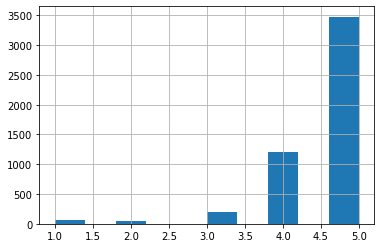

In [19]:
simplified_amazon_reviews_dataset_pd_df['reviews_rating'].hist(bins=10) 

In [20]:
characters_numbers = {}
reviews_number = {}
characters_reviews_ratio = {}

characters_5 = 0
characters_4 = 0
characters_3 = 0
characters_2 = 0
characters_1 = 0

for i in amazon_rating_5:
    characters_5 = characters_5 + len(amazon_rating_5['reviews_text'])
characters_numbers['Rating 5'] = characters_5
reviews_number['Rating 5']  = len(amazon_rating_5)
characters_reviews_ratio['Rating 5'] = characters_5/len(amazon_rating_5)

for i in amazon_rating_4:
    characters_4 = characters_4 + len(amazon_rating_4['reviews_text'])
characters_numbers['Rating 4'] = characters_4
reviews_number['Rating 4']  = len(amazon_rating_4)
characters_reviews_ratio['Rating 4'] = characters_4/len(amazon_rating_4)

for i in amazon_rating_3:
    characters_3 = characters_3 + len(amazon_rating_3['reviews_text'])
characters_numbers['Rating 3'] = characters_3
reviews_number['Rating 3']  = len(amazon_rating_3)
characters_reviews_ratio['Rating 3'] = characters_3/len(amazon_rating_3)

for i in amazon_rating_2:
    characters_2 = characters_2 + len(amazon_rating_2['reviews_text'])
characters_numbers['Rating 2'] = characters_2
reviews_number['Rating 2']  = len(amazon_rating_2)
characters_reviews_ratio['Rating 2'] = characters_2/len(amazon_rating_2)

for i in amazon_rating_1:
    characters_1 = characters_1 + len(amazon_rating_1['reviews_text'])
characters_numbers['Rating 1'] = characters_1
reviews_number['Rating 1']  = len(amazon_rating_1)
characters_reviews_ratio['Rating 1'] = characters_1/len(amazon_rating_2)

print('Total of characers per rating', characters_numbers)
print('Total reviews per rating', reviews_number)
print('Characters to Reviews', characters_reviews_ratio)

Total of characers per rating {'Rating 5': 13912, 'Rating 4': 4832, 'Rating 3': 788, 'Rating 2': 216, 'Rating 1': 252}
Total reviews per rating {'Rating 5': 3478, 'Rating 4': 1208, 'Rating 3': 197, 'Rating 2': 54, 'Rating 1': 63}
Characters to Reviews {'Rating 5': 4.0, 'Rating 4': 4.0, 'Rating 3': 4.0, 'Rating 2': 4.0, 'Rating 1': 4.666666666666667}


In [ ]:
# for i in range(1,6):
# reviewone = ' '.join(list(amazon_reviews_dataset_pd_df[amazon_reviews_dataset_pd_df['reviews.rating']==i]['reviews.text']))
# reviewone_wc = WordCloud(width=512,height=512).generate(reviewone)

# plt.figure(figsize = (5,3), facecolor = 'k')
# plt.imshow(reviewone_wc)
# plt.axis('off')
# plt.tight_layout(pad = 0)
# plt.show()

# Train - Test Split

In [49]:
from sklearn.model_selection import train_test_split 

independent_var, dependent_var = simplified_amazon_reviews_dataset_pd_df.drop("reviews_rating", axis=1), simplified_amazon_reviews_dataset_pd_df["reviews_rating"].copy() 
x_train, x_test, y_train, y_test = train_test_split(independent_var, dependent_var, test_size=0.2, random_state=42)

# NLP with Spark

In [70]:
# Downloading the spaCy english model
#!pip install spacy

In [21]:
#we need only that column for extracting sentiments from customers and for that we need to convert our dataframe into RDD
amz_reviews_rdd = simplified_amazon_reviews_dataset_sql_contex.select("reviews_text").rdd.flatMap(lambda x: x)
#amz_reviews_rdd.collect()

In [23]:
#Remove header and convert all the data into lowercase for easy processing.
header = amz_reviews_rdd.first()
amz_reviews_rmv_col = amz_reviews_rdd.filter(lambda row: row != header)

lowerCase_amz_reviewsRDD = amz_reviews_rmv_col.map(lambda x : x.lower())

In [25]:
#sentence tokenization - Text data is split into sentences 
def sent_TokenizeFunct(x):
    return nltk.sent_tokenize(x)

sentenceTokenizeRDD = lowerCase_amz_reviewsRDD.map(sent_TokenizeFunct)

In [27]:
# split each sentence into words, also called word tokenization
def word_TokenizeFunct(x):
    splitted = [word for line in x for word in line.split()]
    return splitted
wordTokenizeRDD = sentenceTokenizeRDD.map(word_TokenizeFunct)

In [29]:
#clean our data, here we’re gonna remove stopwords, punctuations and empty spaces
from nltk.corpus import stopwords

def removeStopWordsFunct(x):
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

stopwordRDD = wordTokenizeRDD.map(removeStopWordsFunct)

def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

rmvPunctRDD = stopwordRDD.map(removePunctuationsFunct)

In [31]:
# Lemmatization to reduce inflectional and derivationally related forms 
def lemmatizationFunct(x):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem

lem_wordsRDD = rmvPunctRDD.map(lemmatizationFunct)

In [33]:
#extract key phrases. So first we need to join “lem_wordsRDD” tokens.
def joinTokensFunct(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x
joinedTokens = lem_wordsRDD.map(joinTokensFunct)

In [34]:
#chunking, chinking and POS tagging using Regular expression and extracting all the Noun phrases
from nltk.corpus import stopwords

def extractPhraseFunct(x):
    stop_words=set(stopwords.words('english'))
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase

extractphraseRDD = joinedTokens.map(extractPhraseFunct)

In [35]:
# From the above step we roughly got all the key phrases the customers are talking about. 
# Now categorize these key phrases into positive, Negative or Neutral.
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentimentWordsFunct(x):
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []
    for i in x:
        y = ''.join(i) 
        vs = analyzer.polarity_scores(y)
        senti_list_temp.append((y, vs))
        senti_list_temp = [w for w in senti_list_temp if w]
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
    
        for (k,v) in second.items():
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative"))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral"))
                else:
                    sentiment_list.append((first, "Positive"))
    return sentiment_list

sentimentRDD = extractphraseRDD.map(sentimentWordsFunct)

In [36]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/faculty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
freqDistRDD = extractphraseRDD.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 8.0 failed 1 times, most recent failure: Lost task 1.0 in stage 8.0 (TID 44, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/rdd.py", line 352, in func
    return f(iterator)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/rdd.py", line 1861, in combineLocally
    merger.mergeValues(iterator)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py", line 238, in mergeValues
    for k, v in iterator:
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-25-44d39e209d0d>", line 3, in sent_TokenizeFunct
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/nltk/tokenize/__init__.py", line 105, in sent_tokenize
    tokenizer = load('tokenizers/punkt/{0}.pickle'.format(language))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/nltk/data.py", line 868, in load
    opened_resource = _open(resource_url)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/nltk/data.py", line 993, in _open
    return find(path_, path + ['']).open()
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/nltk/data.py", line 701, in find
    raise LookupError(resource_not_found)
LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/faculty/nltk_data'
    - '/opt/anaconda/envs/Python3/nltk_data'
    - '/opt/anaconda/envs/Python3/share/nltk_data'
    - '/opt/anaconda/envs/Python3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1124)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:989)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/rdd.py", line 352, in func
    return f(iterator)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/rdd.py", line 1861, in combineLocally
    merger.mergeValues(iterator)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py", line 238, in mergeValues
    for k, v in iterator:
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-25-44d39e209d0d>", line 3, in sent_TokenizeFunct
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/nltk/tokenize/__init__.py", line 105, in sent_tokenize
    tokenizer = load('tokenizers/punkt/{0}.pickle'.format(language))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/nltk/data.py", line 868, in load
    opened_resource = _open(resource_url)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/nltk/data.py", line 993, in _open
    return find(path_, path + ['']).open()
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/nltk/data.py", line 701, in find
    raise LookupError(resource_not_found)
LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/faculty/nltk_data'
    - '/opt/anaconda/envs/Python3/nltk_data'
    - '/opt/anaconda/envs/Python3/share/nltk_data'
    - '/opt/anaconda/envs/Python3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1124)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [32]:
lem_wordsRDD.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 7.0 failed 1 times, most recent failure: Lost task 0.0 in stage 7.0 (TID 35, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 400, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-25-44d39e209d0d>", line 3, in sent_TokenizeFunct
NameError: name 'nltk' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:989)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 400, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-25-44d39e209d0d>", line 3, in sent_TokenizeFunct
NameError: name 'nltk' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [38]:
# Set voting values.
RATINGONE = 0
RATINGTWO = 1 
RATINGTHREE = 2
RATINGFOUR = 3
RATINGFIVE = 4
ABSTAIN = -1

In [45]:
from snorkel.labeling import labeling_function
import re

# Common words in each of the review levels
ReviewLEVELOne =  r"(cheap|horrible|disappointing|disappointed|difficult|terrible|frustrating|worthless|junk|complicated|worst|bad)"
# I've noticed the use of words that "soften", i.e, not too, not great, too much 
ReviewLEVELTwo = r"(too|because|but|not|much)"
ReviewLEVELThree = r"(solid|smooth|ok|good for)" 
ReviewLEVELFour = r"(good|works well|reliable)" 
ReviewLEVELFive = r"(great|excellent|happy|excited)" 

# labelling functions based off specific words
@labeling_function()
def review_level_one(x):
    return RATINGONE if re.search(ReviewLEVELOne, x.reviews_text.lower()) else ABSTAIN

@labeling_function()
def review_level_two(x):
    return RATINGTWO if re.search(ReviewLEVELTwo, x.reviews_text.lower()) else ABSTAIN

@labeling_function()
def review_level_three(x):
    return RATINGTHREE if re.search(ReviewLEVELThree, x.reviews_text.lower()) else ABSTAIN

@labeling_function()
def review_level_four(x):
    return RATINGFOUR if re.search(ReviewLEVELFour, x.reviews_text.lower()) else ABSTAIN

@labeling_function()
def review_level_five(x):
    return RATINGFIVE if re.search(ReviewLEVELFive, x.reviews_text.lower()) else ABSTAIN

In [42]:
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.apply.spark import SparkLFApplier


labelingfunctions = [review_level_one, review_level_two, review_level_three, review_level_four, review_level_five]

applier = SparkLFApplier(lfs=labelingfunctions)
applied = applier.apply(data_points=amazon_reviews_dataset_rdd)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 13.0 failed 1 times, most recent failure: Lost task 1.0 in stage 13.0 (TID 76, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 400, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/spark.py", line 39, in map_fn
    return apply_lfs_to_data_point(*args, lfs=self._lfs, f_caller=f_caller)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/core.py", line 107, in apply_lfs_to_data_point
    y = f_caller(lf, x)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/core.py", line 28, in __call__
    return f(x)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/lf/core.py", line 77, in __call__
    return self._f(x, **self._resources)
  File "<ipython-input-39-102c14e83217>", line 52, in review_level_one
NameError: name 're' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:989)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 400, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/spark.py", line 39, in map_fn
    return apply_lfs_to_data_point(*args, lfs=self._lfs, f_caller=f_caller)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/core.py", line 107, in apply_lfs_to_data_point
    y = f_caller(lf, x)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/core.py", line 28, in __call__
    return f(x)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/lf/core.py", line 77, in __call__
    return self._f(x, **self._resources)
  File "<ipython-input-39-102c14e83217>", line 52, in review_level_one
NameError: name 're' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [46]:
applier = PandasLFApplier(lfs=labelingfunctions)
L_train = applier.apply(df=amazon_reviews_dataset_pd_df)


100%|██████████| 5000/5000 [00:00<00:00, 11087.14it/s]


In [48]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=labelingfunctions).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
review_level_one,0,[0],0.0426,0.0342,0.0342
review_level_two,1,[1],0.3478,0.2114,0.2114
review_level_three,2,[2],0.1734,0.1248,0.1248
review_level_four,3,[3],0.1346,0.0904,0.0904
review_level_five,4,[4],0.3236,0.1560,0.1560
